In [10]:
# Basic Libraries

import pandas as pd
import numpy as np

pd.plotting.register_matplotlib_converters()
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV

from sklearn.preprocessing import MinMaxScaler


In [11]:
# Libraries for Classification and building Models

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Flatten, Dense, MaxPool2D, Dropout
from tensorflow.keras.utils import to_categorical 

from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC


In [12]:
df = pd.read_csv("Urban_sound_classification/UrbanSound8K.csv")

df.head()

,slice_file_name,fsID,start,end,salience,fold,classID,class
0,100032-3-0-0.wav,100032,0.0,0.317551,1,5,3,dog_bark
1,100263-2-0-117.wav,100263,58.5,62.500000,1,5,2,children_playing
2,100263-2-0-121.wav,100263,60.5,64.500000,1,5,2,children_playing
3,100263-2-0-126.wav,100263,63.0,67.000000,1,5,2,children_playing
4,100263-2-0-137.wav,100263,68.5,72.500000,1,5,2,children_playing


In [13]:
dat1, sampling_rate1 = librosa.load('Urban_sound_classification/fold5/100032-3-0-0.wav')
dat2, sampling_rate2 = librosa.load('Urban_sound_classification/fold5/100263-2-0-117.wav')

Text(0.5, 1.0, 'Linear-frequency power spectrogram')

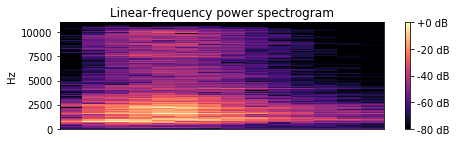

In [36]:
plt.figure(figsize=(16, 9))
D = librosa.amplitude_to_db(np.abs(librosa.stft(dat1)), ref=np.max)
plt.subplot(4, 2, 1)
librosa.display.specshow(D, y_axis='linear')
plt.colorbar(format='%+2.0f dB')
plt.title('Linear-frequency power spectrogram')

In [2]:
### Define helper functions ###

def extract_features(parent_dir,sub_dirs,file_ext="*.wav",
                     bands=60,frames=41):
    def _windows(data, window_size):
        start = 0
        while start < len(data):
            yield int(start), int(start + window_size)
            start += (window_size // 2)
            
    window_size = 512 * (frames - 1)
    features, labels = [], []
    for fn in glob.glob(os.path.join(parent_dir, sub_dir, file_ext)):
        segment_log_specgrams, segment_labels = [], []
        sound_clip,sr = librosa.load(fn)
        label = int(fn.split('/')[2].split('-')[1])
        for (start,end) in _windows(sound_clip,window_size):
            if(len(sound_clip[start:end]) == window_size):
                signal = sound_clip[start:end]
                melspec = librosa.feature.melspectrogram(signal,n_mels=bands)
                logspec = librosa.amplitude_to_db(melspec)
                logspec = logspec.T.flatten()[:, np.newaxis].T
                segment_log_specgrams.append(logspec)
                segment_labels.append(label)
            
        segment_log_specgrams = np.asarray(segment_log_specgrams).reshape(
            len(segment_log_specgrams),bands,frames,1)
        segment_features = np.concatenate((segment_log_specgrams, np.zeros(
            np.shape(segment_log_specgrams))), axis=3)
        for i in range(len(segment_features)): 
            segment_features[i, :, :, 1] = librosa.feature.delta(
                segment_features[i, :, :, 0])
        
        if len(segment_features) > 0: # check for empty segments 
            features.append(segment_features)
            labels.append(segment_labels)
    return features, labels

Text(0.5, 1.0, 'Linear-frequency power spectrogram')

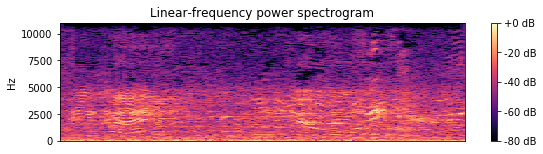

In [15]:
plt.figure(figsize=(20, 10))
D = librosa.amplitude_to_db(np.abs(librosa.stft(dat2)), ref=np.max)
plt.subplot(4, 2, 1)
librosa.display.specshow(D, y_axis='linear')
plt.colorbar(format='%+2.0f dB')
plt.title('Linear-frequency power spectrogram')

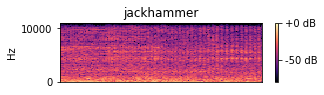

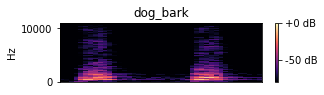

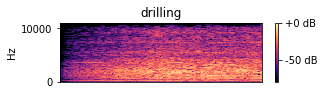

In [16]:
'''Using random samples to observe difference in waveforms.'''

arr = np.array(df["slice_file_name"])
fold = np.array(df["fold"])
cla = np.array(df["class"])

for i in range(192, 197, 2):
    path = 'Urban_sound_classification/fold' + str(fold[i]) + '/' + arr[i]
    data, sampling_rate = librosa.load(path)
    plt.figure(figsize=(10, 5))
    D = librosa.amplitude_to_db(np.abs(librosa.stft(data)), ref=np.max)
    plt.subplot(4, 2, 1)
    librosa.display.specshow(D, y_axis='linear')
    plt.colorbar(format='%+2.0f dB')
    plt.title(cla[i])

In [17]:
'''EXAMPLE'''

dat1, sampling_rate1 = librosa.load('Urban_sound_classification/fold5/100032-3-0-0.wav')
arr = librosa.feature.melspectrogram(y=dat1, sr=sampling_rate1)
arr.shape

(128, 14)

In [18]:
feature = []
label = []

def parser(row):
    # Function to load files and extract features
    for i in range(8732):
        file_name = 'Urban_sound_classification/fold' + str(df["fold"][i]) + '/' + df["slice_file_name"][i]
        # Here kaiser_fast is a technique used for faster extraction
        X, sample_rate = librosa.load(file_name, res_type='kaiser_fast') 
        # We extract mfcc feature from data
        mels = np.mean(librosa.feature.melspectrogram(y=X, sr=sample_rate).T,axis=0)        
        feature.append(mels)
        label.append(df["classID"][i])
    return [feature, label]

In [19]:
temp = parser(df)

/Users/nbhadra/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1323
  n_fft, y.shape[-1]
/Users/nbhadra/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1103
  n_fft, y.shape[-1]
/Users/nbhadra/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1523
  n_fft, y.shape[-1]


In [20]:
temp = np.array(temp)
data = temp.transpose()

In [21]:
X_ = data[:, 0]
Y = data[:, 1]
print(X_.shape, Y.shape)
X = np.empty([8732, 128])

(8732,) (8732,)


In [22]:
for i in range(8732):
    X[i] = (X_[i])

In [23]:
Y = to_categorical(Y)


In [24]:
'''Processed Data'''
print(X.shape)
print(Y.shape)

(8732, 128)
(8732, 10)


In [25]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, random_state = 1)


In [26]:
X_train = X_train.reshape(6549, 16, 8, 1)
X_test = X_test.reshape(2183, 16, 8, 1)

In [27]:
input_dim = (16, 8, 1)


In [28]:
model = Sequential()


In [29]:
model.add(Conv2D(64, (3, 3), padding = "same", activation = "tanh", input_shape = input_dim))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Conv2D(128, (3, 3), padding = "same", activation = "tanh"))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.1))
model.add(Flatten())
model.add(Dense(1024, activation = "tanh"))
model.add(Dense(10, activation = "softmax"))

In [30]:
model.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])

In [31]:
model.fit(X_train, Y_train, epochs = 90, batch_size = 50, validation_data = (X_test, Y_test))

Epoch 1/90
131/131 [==============================] - 4s 27ms/step - loss: 1.5388 - accuracy: 0.4775 - val_loss: 1.2627 - val_accuracy: 0.5703
Epoch 2/90
131/131 [==============================] - 3s 20ms/step - loss: 1.1439 - accuracy: 0.6146 - val_loss: 1.0990 - val_accuracy: 0.6290
Epoch 3/90
131/131 [==============================] - 3s 20ms/step - loss: 0.9712 - accuracy: 0.6699 - val_loss: 1.0039 - val_accuracy: 0.6642
Epoch 4/90
131/131 [==============================] - 3s 21ms/step - loss: 0.8541 - accuracy: 0.7174 - val_loss: 0.9329 - val_accuracy: 0.7174
Epoch 5/90
131/131 [==============================] - 3s 20ms/step - loss: 0.7667 - accuracy: 0.7442 - val_loss: 0.8895 - val_accuracy: 0.7142
Epoch 6/90
131/131 [==============================] - 3s 20ms/step - loss: 0.6901 - accuracy: 0.7684 - val_loss: 0.8885 - val_accuracy: 0.7270
Epoch 7/90
131/131 [==============================] - 3s 21ms/step - loss: 0.6386 - accuracy: 0.7911 - val_loss: 0.9540 - val_accuracy: 0.7022

Epoch 58/90
131/131 [==============================] - 3s 20ms/step - loss: 0.0924 - accuracy: 0.9696 - val_loss: 0.8627 - val_accuracy: 0.8447
Epoch 59/90
131/131 [==============================] - 3s 20ms/step - loss: 0.0924 - accuracy: 0.9707 - val_loss: 0.8404 - val_accuracy: 0.8530
Epoch 60/90
131/131 [==============================] - 3s 20ms/step - loss: 0.1283 - accuracy: 0.9572 - val_loss: 0.8485 - val_accuracy: 0.8406
Epoch 61/90
131/131 [==============================] - 3s 20ms/step - loss: 0.1049 - accuracy: 0.9664 - val_loss: 0.8250 - val_accuracy: 0.8548
Epoch 62/90
131/131 [==============================] - 3s 21ms/step - loss: 0.0855 - accuracy: 0.9714 - val_loss: 0.7757 - val_accuracy: 0.8562
Epoch 63/90
131/131 [==============================] - 4s 31ms/step - loss: 0.0900 - accuracy: 0.9724 - val_loss: 0.8100 - val_accuracy: 0.8511
Epoch 64/90
131/131 [==============================] - 4s 31ms/step - loss: 0.0726 - accuracy: 0.9756 - val_loss: 0.7790 - val_accuracy:

In [32]:
model.summary()


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 16, 8, 64)         640       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 8, 4, 64)          0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 8, 4, 128)         73856     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 4, 2, 128)         0         
_________________________________________________________________
dropout (Dropout)            (None, 4, 2, 128)         0         
_________________________________________________________________
flatten (Flatten)            (None, 1024)              0         
_________________________________________________________________
dense (Dense)                (None, 1024)              1

In [33]:
predictions = model.predict(X_test)
score = model.evaluate(X_test, Y_test)
print(score)

69/69 [==============================] - 0s 4ms/step - loss: 0.8725 - accuracy: 0.8740
[0.8724519610404968, 0.8740265965461731]


In [34]:
preds = np.argmax(predictions, axis = 1)
